# TWSB (Spirit of Vancouver Island) Thermosalinograph Data Example

![gif](../figures/twsb_thermosalinograph.gif "gif")

In this example, you will be using ONCToolbox to import data frm the BC Ferry Spirit of Vancouver Island (SOVI), clean up the data using some engineering outputs, compute sea surface density, and then create an animation of the vessel in motion.

In [1]:
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import gsw
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
import xarray as xr

from ONCToolbox import ONCToolbox, nan_onc_flags

In [2]:
onct = ONCToolbox()

In [3]:
date_from = datetime(2025,7,30,0,0,0,0) # Start of the data request.
date_to = datetime(2025,7,30,23,59,59,999999) # End of the data request.

## Discovery

In [4]:
all_locs = onct.get_locations(date_from=date_from, date_to=date_to)
twsb_locs = all_locs.where(all_locs.locationCode.str.contains('TWSB')).dropna(how='all')
loc_codes = twsb_locs['locationCode'].to_list()

print('Possible TWSB Combinations Over Requested Times')
print('----------------------------------------------')
for loc_code in loc_codes:
    device_deps = onct.get_deployments(location_code=loc_code, date_from = date_from, date_to = date_to)
    dev_cats = device_deps['deviceCategoryCode'].tolist()
    for dev_cat in dev_cats:
        print(f'{loc_code}: {dev_cat}')

Possible TWSB Combinations Over Requested Times
----------------------------------------------
TWSB: OXYSENSOR
TWSB: PVCS
TWSB: METSTN
TWSB: ORIENTATION
TWSB: BARPRESS
TWSB: TEMPHUMID
TWSB: TSG
TWSB: TURBCHLFL
TWSB.N1: NAV


## Obtain Navigation, PVCS, and Thermosalinograph Data

In [5]:
nav = onct.get_fullres_data(location_code = 'TWSB.N1', 
                            device_category_code = 'NAV', 
                            date_from = date_from, 
                            date_to = date_to, 
                            out_as = 'xarray', 
                            add_metadata = True)

pvcs = onct.get_fullres_data(location_code = 'TWSB', 
                            device_category_code = 'PVCS', 
                            date_from = date_from, 
                            date_to = date_to, 
                            out_as = 'xarray', 
                            add_metadata = True)

tsg = onct.get_fullres_data(location_code = 'TWSB',
                            device_category_code = 'TSG', 
                            date_from = date_from,
                            date_to = date_to, 
                            out_as = 'xarray', 
                            add_metadata = True)

## Combine and Clean Data

In [6]:
twsb = xr.combine_by_coords([nav, pvcs, tsg], combine_attrs='drop_conflicts', join = 'outer')

In [7]:
linear_matchup_vars = ['latitude', 'longitude', 'pump_current','outlet_flow']
for lmv in linear_matchup_vars:
    twsb[lmv] = twsb[lmv].interpolate_na(dim = 'time', method = 'linear', max_gap = timedelta(milliseconds = 3000))

nearest_matchup_vars = ['system_state', 'valve_position']
for nmv in nearest_matchup_vars:
    twsb[nmv] = twsb[nmv].interpolate_na(dim = 'time', method = 'nearest', max_gap = timedelta(milliseconds = 3000))

In [8]:
# Remove science data based on other engineering data. 
# If the following conditions are not met, then we consider ALL flowthrough data at that time to be invalid.
twsb = twsb.where(twsb['system_state'] == 1, drop = True)
twsb = twsb.where(twsb['valve_position'] == 1, drop = True)
twsb = twsb.where(twsb['outlet_flow'] >= 1, drop = True)
twsb = twsb.where(twsb['pump_current'] >= 1, drop = True)

# Also remove any data that failed ONC QAQC tests. 
# The nan_onc_flags utility function only nullifies data in the corresponding variable.
twsb = nan_onc_flags(twsb, flags_to_nan=[4]) 

## Calculate Sea Surface Density

In [9]:
depth = twsb.attrs['depth']
p = gsw.p_from_z(depth, twsb['latitude']) # The intake is approximately 3 meters below the average water line of the vessel.
sa = gsw.SA_from_SP(twsb['practical_salinity'], p, twsb['longitude'], twsb['latitude']) # Absolute Salinity
ct = gsw.CT_from_t(sa, twsb['temperature'], p) # Conservative Temperature
twsb['density'] = gsw.density.rho(sa, ct, p) 

In [10]:
# Resample to 30 second intervals to reduce the number of points to plot.
twsb = twsb.resample({'time': '30s'}, skipna = True).mean()

# Only keep variables of interest and remove any nans to simplify plotting.
twsb = twsb[['latitude','longitude','density']].dropna(dim = 'time', how = 'any')

In [11]:
class Tsawwassen:
    latitude: float = 49.006621
    longitude: float = -123.132309
    
class SwartzBay:
    latitude: float = 48.689047
    longitude: float = -123.410817

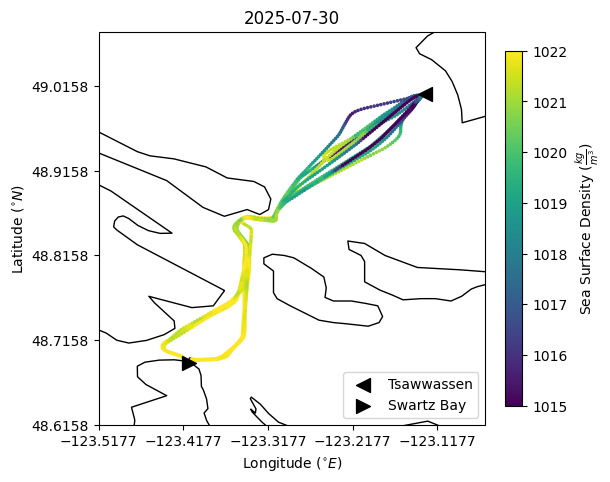

In [12]:
t = twsb.time.values
x = twsb.longitude.values
y = twsb.latitude.values
c = twsb.density.values

xmin, xmax = np.nanmin(x) - 0.075, np.nanmax(x) + 0.075
ymin, ymax = np.nanmin(y)  - 0.075, np.nanmax(y)  + 0.075
major_locator = 0.1 
vmin, vmax = 1015,1022 # Density min/max for color scale.

cmap = matplotlib.colormaps.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin = vmin , vmax = vmax) 

crs = ccrs.PlateCarree()
fig, ax = plt.subplots(1,1,figsize = (6,6), constrained_layout = True, subplot_kw={'projection': crs})
ax.set_extent([xmin, xmax, ymin, ymax])
ax.coastlines()

pscat = ax.scatter(x, y, c = c, cmap = 'viridis', vmin = vmin, vmax = vmax, s=10, marker = '.')
ax.set_title(pd.to_datetime(t[0]).strftime('%Y-%m-%d'))
ax.set_xticks(np.arange(xmin, xmax,major_locator))
ax.set_yticks(np.arange(ymin, ymax,major_locator))
ax.set_xlabel(r'Longitude ($^{\circ}E$)')
ax.set_ylabel(r'Latitude ($^{\circ}N$)')
cbar = fig.colorbar(pscat, ax = ax, cmap = cmap, norm = norm, label = r'Sea Surface Density ($\frac{kg}{m^3}$)', shrink = 0.6)

ax.scatter(Tsawwassen.longitude, Tsawwassen.latitude, marker = '<', color = 'black', s = 100, label = 'Tsawwassen')
ax.scatter(SwartzBay.longitude, SwartzBay.latitude, marker = '>', color = 'black', s = 100, label = 'Swartz Bay')

ax.legend(loc = 'lower right')

plt.show()

In [13]:
t = twsb.time.values
x = twsb.longitude.values
y = twsb.latitude.values
c = twsb.density.values

xmin, xmax = np.nanmin(x) - 0.075, np.nanmax(x) + 0.075
ymin, ymax = np.nanmin(y)  - 0.075, np.nanmax(y)  + 0.075
major_locator = 0.1 
vmin, vmax = 1015,1022 # Density min/max for color scale.

cmap = matplotlib.colormaps.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin = vmin , vmax = vmax) 

crs = ccrs.PlateCarree()
fig, ax = plt.subplots(1,1,figsize = (6,6), constrained_layout = True, subplot_kw={'projection': crs})
ax.set_extent([xmin, xmax, ymin, ymax])
ax.coastlines()

pscat = ax.scatter(x[0], y[0], c = c[0], cmap = 'viridis', vmin = vmin, vmax = vmax, s=10, marker = '.')
ax.set_title(pd.to_datetime(t[0]).strftime('%Y-%m-%dT%H:%M:%SZ'))
ax.set_xticks(np.arange(xmin, xmax,major_locator))
ax.set_yticks(np.arange(ymin, ymax,major_locator))
ax.set_xlabel(r'Longitude ($^{\circ}E$)')
ax.set_ylabel(r'Latitude ($^{\circ}N$)')
cbar = fig.colorbar(pscat, ax = ax, cmap = cmap, norm = norm, label = r'Sea Surface Density ($\frac{kg}{m^3}$)', shrink = 0.6)


ax.scatter(Tsawwassen.longitude, Tsawwassen.latitude, marker = '<', color = 'black', s = 100, label = 'Tsawwassen')
ax.scatter(SwartzBay.longitude, SwartzBay.latitude, marker = '>', color = 'black', s = 100, label = 'Swartz Bay')

ax.legend(loc = 'lower right')


def update(frame):
    data = np.stack([x[:frame], y[:frame]]).T
    pscat.set_offsets(data)
    pscat.set_color(cmap(norm(c[:frame])))
    ax.set_title(pd.to_datetime(t[frame]).strftime('%Y-%m-%dT%H:%M:%SZ'))
    
    return pscat,

ani = FuncAnimation(fig=fig, func=update, frames=len(t), interval=1, blit = False)
ani.save('../figures/twsb_thermosalinograph.gif')
plt.close()